# Assignment 5: Tracking of a moving object which trajectory is disturbed by random acceleration

## Team №6:
1. Angelina Prokopeva
2. Nikita Gorbadey
3. Mark Griguletskii
4. Stanislav Savushkin

03.10.2019, Skoltech

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [79]:
generate_report = False
def plot(trace_num, x_data, y_data, xlable = 'xlable', ylable = 'ylable',
                legend = 'legend', title = 'title', mode='lines'):
    plot.counter += 1
    fig_name = 'images/' + str(plot.counter) + '.jpg'
    fig = go.Figure()
    for i in range(trace_num):
        fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode=mode, name=legend[i], showlegend = True))
    fig.update_layout(
        title=go.layout.Title(
            text=title,
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text=xlable
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=ylable
            )
        )
    )
    if generate_report is True:
        fig.write_image(fig_name)
        display(Image(fig_name))
    else:
        fig.show()
plot.counter = 0

### Working progress

In [80]:
def motion_tragectory(size, T, sigma_a, X_init=0, V_init=0):
    "Function for generating motion trajectory with normally distributed random acceleration"
    out = np.empty(size)
    V = np.empty(size)
    out[0] = X_init
    V[0] = V_init
    a = np.random.normal(loc=0, scale=sigma_a, size=size)
    for i in range(1, size):
        V[i] = V[i-1] + a[i-1]*T
        out[i] = out[i-1] + V[i-1]*T + (a[i-1]*T**2)/2
    return out

In [81]:
def measured_trajectory(data, sigma):
    "Supplementary function for generating measured trajectory"
    return np.add(data, np.random.normal(loc=0, scale=sigma, size=data.size))

**Generating a true trajectory 𝑋𝑖 and its measurements of an object motion disturbed by normally distributed random acceleration with given parameters**

In [82]:
N = 200
X_init = 5
V_init = 1
T = 1
sigma_a = 0.2
sigma_n = 20

# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory(X, sigma_n)
num_points = np.linspace(1, N, num=N)

ValueError: operands could not be broadcast together with shapes (200,2) (400,) 

In [83]:
plot(2, [num_points, num_points], [x, z], title='Random walk trajectory', xlable='points', ylable='value',
     legend=['real trajectory', 'measured trajectory'])

In [63]:
shape = (x.size, 2)
X = np.zeros(size)
X_prev = np.zeros(size)
F = np.array([[1, T], [0, 1]])
G = np.array([T**2/2, T]).T
H = np.array([1, 0])

In [68]:
X_0 = np.array([2, 0]).T
P_0_0 = np.array([[10000, 0], [0, 10000]])

Q = G.dot(G.T.dot(sigma_a**2))
R = sigma_n**2
P = np.zeros((shape[0], 2, 2))
P_prev = np.zeros((shape[0], 2, 2))
K = np.zeros(shape)

X_prev[0] = X_0
P_prev[0] = P_0_0

for i in range(1, shape[0]):
    X[i] = F.dot(X_prev[i-1])
    P[i] = np.dot(F, np.dot(P_prev[i-1], F.T)) + Q

    K[i] = P[i].dot(H.T)/(H.dot(P[i]).dot(H.T) + R)
    X_prev[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
    P_prev = (np.eye(shape[1]) - np.outer(K[i], H)).dot(P[i])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [66]:
shape[0]

200

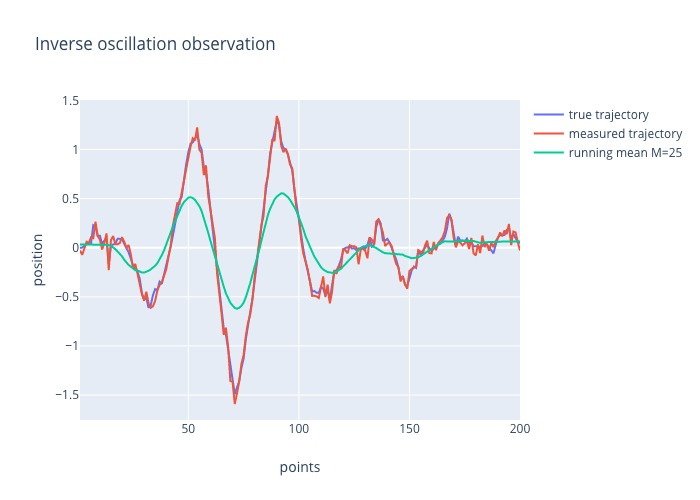